In [1]:
# download train + test datasets
train_dataset = {"path": "../datasets/train-dataset", 
                 "url": "http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip"}
test_dataset = {"path": "../datasets/test-dataset",
                "url": "http://data.celltrackingchallenge.net/test-datasets/Fluo-N2DH-GOWT1.zip"}

# shell commands
!mkdir -p datasets
!wget -nc -O {train_dataset["path"]}.zip {train_dataset["url"]}
!wget -nc -O {test_dataset["path"]}.zip {test_dataset["url"]}
!unzip -n {train_dataset["path"]}.zip -d {train_dataset["path"]}
!unzip -n {test_dataset["path"]}.zip -d {test_dataset["path"]}

File ‘../datasets/train-dataset.zip’ already there; not retrieving.
File ‘../datasets/test-dataset.zip’ already there; not retrieving.
Archive:  ../datasets/train-dataset.zip
Archive:  ../datasets/test-dataset.zip


In [2]:
import torch
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path

# set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device:\t{DEVICE}")


device:	cpu


Text(0.5, 1.0, 'y_train')

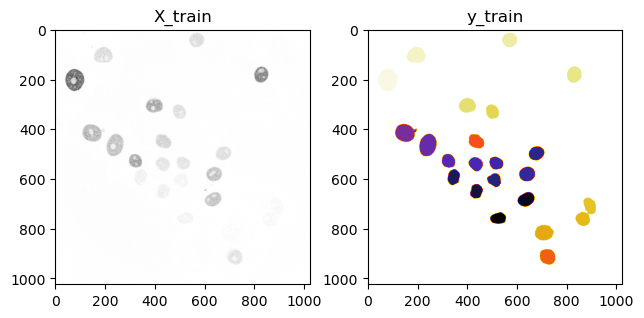

In [3]:
# load tif images as np.uint8
X_train = plt.imread(f"{train_dataset['path']}/Fluo-N2DH-GOWT1/01/t000.tif")
y_train = plt.imread(f"{train_dataset['path']}/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg000.tif")

# plot and example train-test pair
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].imshow(X_train, cmap="binary")
axs[0].set_title("X_train")
axs[1].imshow(y_train, cmap="CMRmap_r")
axs[1].set_title("y_train")


In [4]:
class SegmentationDataset(data.Dataset):
    def __init__(self, X_path, y_path, preprocess_transforms=None, augmentation_transforms=None):
        """Create a segmentation dataset for pytorch dataloader.

        Parameters
        ----------
        X_path : str
            Path to the directory with raw images.
        y_path : str
            Path to the directory with labeled images.
        preprocess_transforms : torchvision.transforms.Compose, optional
            Transforms to be applies on train/validation/test images, by default None
        augmentation_transforms : torchvision.transforms.Compose, optional
            Transforms to be applied on train images only, by default None
        """
        self.X_path = X_path
        self.y_path = y_path
        self.preprocess_transforms = preprocess_transforms
        self.augmentation_transforms = augmentation_transforms
        self.X = sorted(Path(self.X_path).glob("*.tif"))
        self.y = sorted(Path(self.y_path).glob("*.tif"))
        assert len(self.X) == len(self.y), "len(X) != len(y)"

    def __len__(self):
        """number of training images"""
        return len(self.y)

    def __getitem__(self, idx):
        """load X-y image pair"""

        # load images as tensors
        X_img = plt.imread(self.X[idx])
        y_img = plt.imread(self.y[idx])
        y_img = y_img[y_img != 0] = 1  # binarize

        # apply image transformations
        if self.preprocess_transforms:
            X_img = self.preprocess_transforms(X_img)
            y_img = self.preprocess_transforms(y_img)

        if self.augmentation_transforms:
            X_img = self.augmentation_transforms(X_img)
            y_img = self.augmentation_transforms(y_img)

        return X_img, y_img


def get_data_loaders(
    X_path,
    y_path,
    batch_size=20,
    seed=2023,
    augmentation_transforms=True,
):
    """Helper function to initialize pytorch dataloaders.

    Parameters
    ----------
    X_path : str
        Path to the directory with raw images.
    y_path : str
        Path to the directory with labeled images.
    batch_size : int, optional
        Number of samples / batch to load, by default 20
    seed : int, optional
        Random seed, by default 2023
    augmentation_transforms : bool, optional
        Whether to apply augmentation transformations to training sets.

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        Dataloader for the training set.
    val_loader : torch_utils.data.DataLoader
        Dataloader for the validation set.
    """

    # random number generator
    rng = torch.Generator().manual_seed(seed)

    # transformations to train/validation/test images
    preprocess_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize([572, 572], antialias=True)]
    )  # for input to U-Net

    # transformations to train images
    if augmentation_transforms:
        augmentation_transforms = transforms.Compose(
            [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()]
        )
    else:
        augmentation_transforms = None

    # train-validation split
    segmentation_dataset = SegmentationDataset(
        X_path, y_path, preprocess_transforms, augmentation_transforms
    )
    train_dataset, val_dataset = data.random_split(segmentation_dataset, [0.8, 0.2], generator=rng)

    train_loader = data.DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size, shuffle=True)

    return train_loader, val_loader


In [5]:
def test_get_data_loaders(X_path, y_path):
    """Test that data loaders are working as expected"""
    batch_size = 37
    train_loader, val_loader = get_data_loaders(X_path, y_path, batch_size)

    assert len(train_loader.dataset) > 0, "training set is empty"
    assert len(val_loader.dataset) > 0, "validation set is empty"
    assert len(train_loader.dataset) / len(train_loader) == batch_size, "batch_size error"


test_get_data_loaders(
    f"{train_dataset['path']}/Fluo-N2DH-GOWT1/01",
    f"{train_dataset['path']}/Fluo-N2DH-GOWT1/01_ST/SEG",
)
